In [10]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.pyplot as mpl
import matplotlib.cm as cm
from drama import utils

# Multilooking 
The following cell inplements a simple function to _multilook_ an image using a _moving average_, i.e. a boxcar filter.

In [11]:
def moving_average(data, Naz, Nrg, downsample=False):
    """ A moving average filter for you
    Args:
        data: 2D numpy array
        Naz: number of samples averaged in azimuth (first dimension)
        Nrg: number of samples averaged in range (second dimension)
        downsample: True if you want to downsample after averaging
    """
    filt_data = utils.smooth(utils.smooth(data, Nrg, axis=1), Naz, axis=0)
    if downsample:
        filt_data = filt_data[int(Naz/2)::Naz, int(Nrg/2)::Nrg]
    return filt_data

# Chessboard with speckle
In the following cell we create speckle following a checkboard pattern.

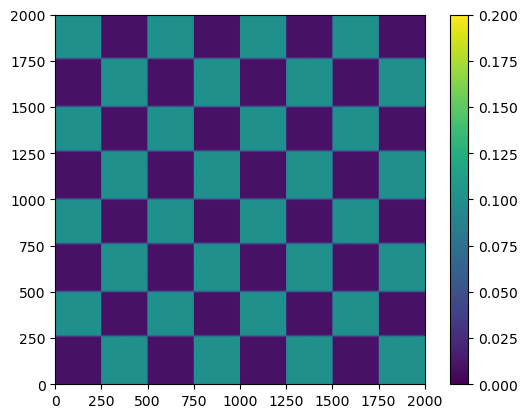

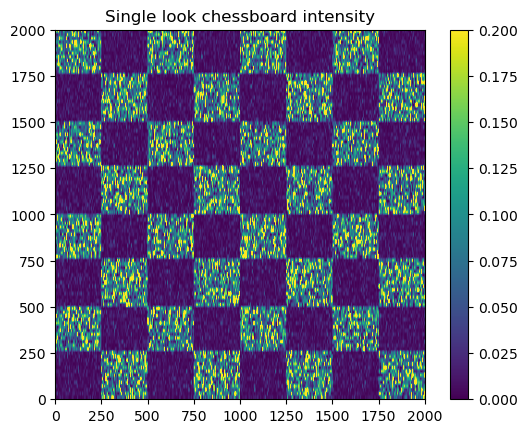

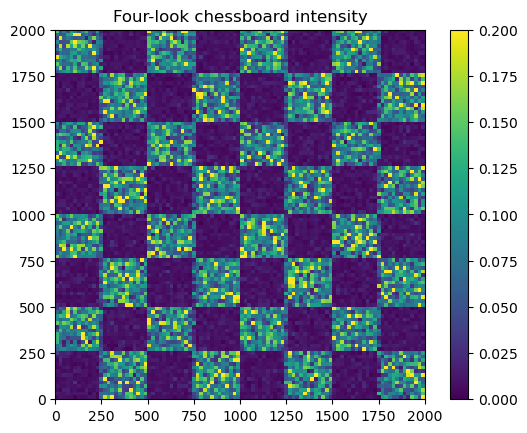

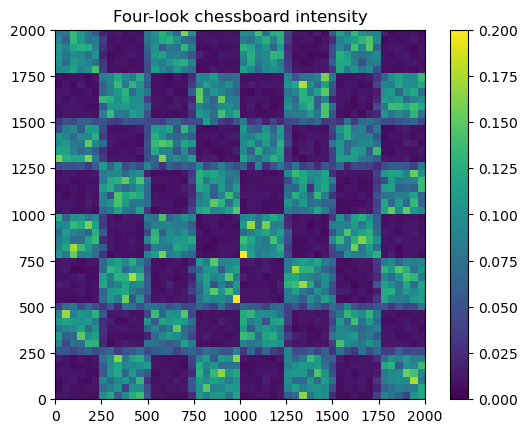

In [12]:
def chessboard_nrcs(shape, nrcs_black=0.01, nrcs_white=0.1, square_size=100, daz=20, dgr=5):
    """ Creates a chessboard pattern
    
    Args:
        shape: shape of output matrix
        nrcs_black (float):  nrcs for black squares. User decides if these are db or linear values.
        nrcs_white (float): nrcs for white squares...
        square_size (float): size of each square, in meters. Defaults to 100.
        daz (float): azimuth resolution (or in this case sampling). Defaults to 20 m.
        dgr (float): ground range resolution (sampling). Defaults to 5 m.
        
    """
    # This can be done in many ways, so do not put too much value in this particular implementation.
    aind = np.arange(shape[0]).reshape((shape[0], 1))
    rind = np.arange(shape[1]).reshape((1, shape[1]))
    apat = np.int32(aind*daz/square_size)
    rpat = np.int32(rind*dgr/square_size)
    chess_board = np.mod(apat + rpat, 2)
    chess_board = chess_board * (nrcs_white - nrcs_black) + nrcs_black
    return chess_board

# Let is try it, this shows the pattern without speckle
cbrd_nrcs = chessboard_nrcs((100, 400), 0.01, 0.1, square_size=250)
plt.figure()
plt.imshow(cbrd_nrcs, origin='lower', extent=(0,2000,0,2000), vmin=0, vmax=0.2)
plt.colorbar()
# Now to simulate an SAR image we need to multiply the random speckle by the deterministic pattern:
cbrd_slc  = np.sqrt(cbrd_nrcs/2) * (np.random.randn(100,400) + 1j*np.random.randn(100,400))
plt.figure()
plt.imshow(np.abs(cbrd_slc)**2, origin='lower', extent=(0,2000,0,2000), vmin=0, vmax=0.2)
plt.title("Single look chessboard intensity")
plt.colorbar()
# We can do some multilooking
cbrd_int_4looks = moving_average(np.abs(cbrd_slc)**2, 1, 4, downsample=True)
plt.figure()
plt.imshow(cbrd_int_4looks, origin='lower', extent=(0,2000,0,2000), vmin=0, vmax=0.2)
plt.title("Four-look chessboard intensity")
plt.colorbar()
cbrd_int_16looks = moving_average(np.abs(cbrd_slc)**2, 2, 8, downsample=True)
plt.figure()
plt.imshow(cbrd_int_16looks, origin='lower', extent=(0,2000,0,2000), vmin=0, vmax=0.2)
plt.title("Four-look chessboard intensity")
plt.colorbar()

In [13]:
import numpy as np

# Define the image size and resolution
shape = (50, 200)  # 50 rows (azimuth) x 200 columns (range)
square_size = 100  # Size of each square in meters
daz = 20  # Azimuth resolution
dgr = 5   # Range resolution

# Generate the chessboard NRCS pattern
nrcs = chessboard_nrcs(shape, nrcs_black=0.01, nrcs_white=0.1, 
                       square_size=square_size, daz=daz, dgr=dgr)

print(nrcs.shape)  # Confirm the shape is (50, 200)


(50, 200)


In [14]:
# Add complex Gaussian speckle noise
slc = np.sqrt(nrcs / 2) * (np.random.randn(*shape) + 1j * np.random.randn(*shape))

# Calculate the magnitude (intensity) of the speckle-corrupted image
intensity_image = np.abs(slc)


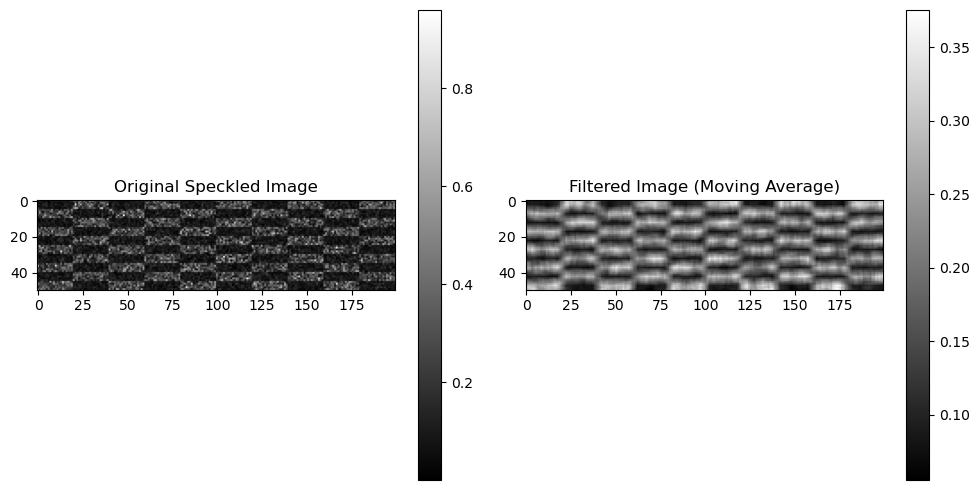

In [15]:
# Define smoothing parameters
Naz = 5  # Number of samples to average in azimuth
Nrg = 5  # Number of samples to average in range

# Apply the moving average filter
filtered_image = moving_average(intensity_image, Naz, Nrg)

# Compare the original and filtered images
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

# Original image
plt.subplot(1, 2, 1)
plt.title("Original Speckled Image")
plt.imshow(intensity_image, cmap='gray')
plt.colorbar()

# Filtered image
plt.subplot(1, 2, 2)
plt.title("Filtered Image (Moving Average)")
plt.imshow(filtered_image, cmap='gray')
plt.colorbar()

plt.tight_layout()
plt.show()


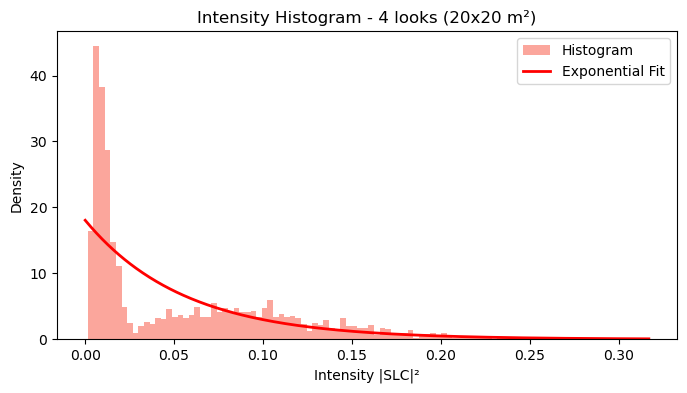

4 looks (20x20 m²):
  Mean Intensity: 0.0554
  Standard Deviation: 0.0571



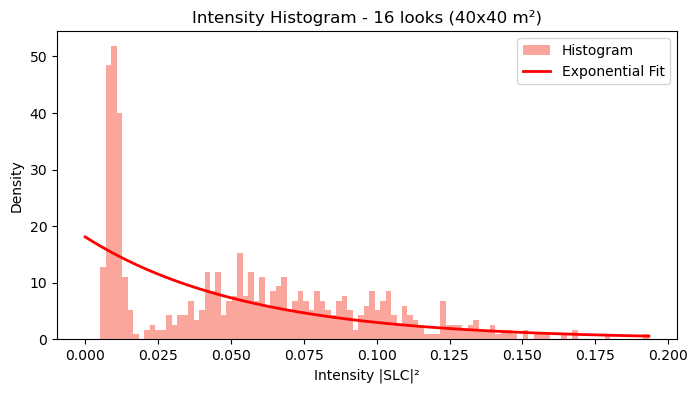

16 looks (40x40 m²):
  Mean Intensity: 0.0553
  Standard Deviation: 0.0410



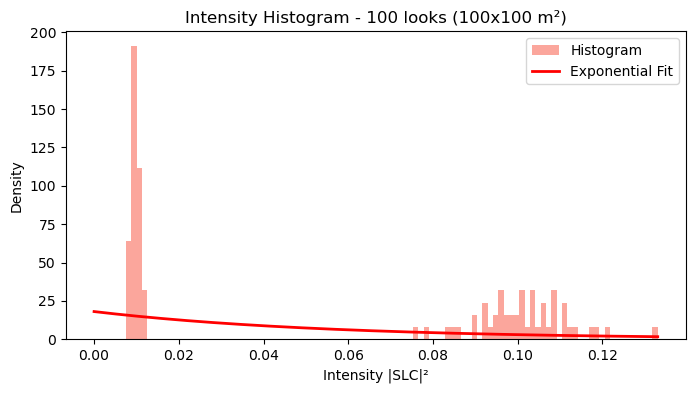

100 looks (100x100 m²):
  Mean Intensity: 0.0555
  Standard Deviation: 0.0463



In [17]:
from scipy.stats import rayleigh, expon
from drama import utils  # Assuming utils.smooth is available

# Parameters
shape = (50, 200)  # 50 rows (azimuth) x 200 columns (range)
square_size = 100  # Size of each square in meters
daz = 20  # Azimuth resolution
dgr = 5   # Range resolution

# Create the chessboard NRCS
ex_nrcs = chessboard_nrcs(shape, nrcs_black=0.01, nrcs_white=0.1, 
                          square_size=square_size, daz=daz, dgr=dgr)

# Define the multilook parameters
multilook_params = [
    {"Naz": 1, "Nrg": 4, "label": "4 looks (20x20 m²)"},
    {"Naz": 2, "Nrg": 8, "label": "16 looks (40x40 m²)"},
    {"Naz": 5, "Nrg": 20, "label": "100 looks (100x100 m²)"}
]

def multilook_and_plot(nrcs, params):
    for param in params:
        Naz = param["Naz"]
        Nrg = param["Nrg"]
        label = param["label"]
        
        slc = np.sqrt(nrcs/2) * (np.random.randn(50,200) + 1j*np.random.randn(50,200))

        # Compute multilooked intensity
        multilooked_intensity = moving_average(np.abs(slc)**2, Naz, Nrg, downsample=True)
        
        # Compute statistics
        mean_intensity = np.mean(multilooked_intensity)
        std_intensity = np.std(multilooked_intensity)
        
        # Plot histogram
        plt.figure(figsize=(8, 4))
        plt.hist(multilooked_intensity.flatten(), bins=100, density=True, color='salmon', alpha=0.7, label='Histogram')
        x = np.linspace(0, multilooked_intensity.max(), 500)
        plt.plot(x, expon.pdf(x, scale=mean_intensity), 'r-', lw=2, label="Exponential Fit")
        plt.title(f"Intensity Histogram - {label}")
        plt.xlabel("Intensity |SLC|²")
        plt.ylabel("Density")
        plt.legend()
        plt.show()
        
        print(f"{label}:")
        print(f"  Mean Intensity: {mean_intensity:.4f}")
        print(f"  Standard Deviation: {std_intensity:.4f}\n")

# Run the multilooking process and plot results
multilook_and_plot(ex_nrcs, multilook_params)


In [18]:
import numpy as np
from drama import utils

def moving_average(data, Naz, Nrg, downsample=False):
    """A moving average filter for multilooking."""
    filt_data = utils.smooth(utils.smooth(data, Nrg, axis=1), Naz, axis=0)
    if downsample:
        filt_data = filt_data[int(Naz/2)::Naz, int(Nrg/2)::Nrg]
    return filt_data

# Example SLC data (simulate radar image with speckle)
np.random.seed(0)  # For reproducibility
shape = (50, 200)  # 50 rows (azimuth) x 200 columns (range)
nrcs = 0.1
slc = np.sqrt(nrcs/2) * (np.random.randn(*shape) + 1j * np.random.randn(*shape))

# Compute the squared amplitude (intensity)
intensity = np.abs(slc)**2  # Squared amplitude

# Apply multilooking (average intensities)
# For example: 4 looks = 1x4 window
Naz, Nrg = 1, 4
intensity_4looks = moving_average(intensity, Naz, Nrg, downsample=True)

# For 16 looks = 2x8 window
Naz, Nrg = 2, 8
intensity_16looks = moving_average(intensity, Naz, Nrg, downsample=True)

# For 100 looks = 5x20 window
Naz, Nrg = 5, 20
intensity_100looks = moving_average(intensity, Naz, Nrg, downsample=True)

# Print shapes and stats
print("Original intensity shape:", intensity.shape)
print("4-looks intensity shape:", intensity_4looks.shape)
print("16-looks intensity shape:", intensity_16looks.shape)
print("100-looks intensity shape:", intensity_100looks.shape)

print("\nMean and Standard Deviation:")
print(f"4 Looks -> Mean: {np.mean(intensity_4looks):.4f}, Std: {np.std(intensity_4looks):.4f}")
print(f"16 Looks -> Mean: {np.mean(intensity_16looks):.4f}, Std: {np.std(intensity_16looks):.4f}")
print(f"100 Looks -> Mean: {np.mean(intensity_100looks):.4f}, Std: {np.std(intensity_100looks):.4f}")


Original intensity shape: (50, 200)
4-looks intensity shape: (50, 50)
16-looks intensity shape: (25, 25)
100-looks intensity shape: (10, 10)

Mean and Standard Deviation:
4 Looks -> Mean: 0.0981, Std: 0.0484
16 Looks -> Mean: 0.0981, Std: 0.0236
100 Looks -> Mean: 0.0981, Std: 0.0093


In [28]:
# Example SLC data (simulate radar image with speckle)
np.random.seed(0)  # For reproducibility
shape = (50, 200)  # 50 rows (azimuth) x 200 columns (range)
nrcs = 0.1
slc = np.sqrt(nrcs/2) * (np.random.randn(*shape) + 1j * np.random.randn(*shape))

# Compute the squared amplitude (intensity)
intensity = np.abs(slc)**2  # Squared amplitude


def plot_intensity(intensity, Naz, Nrg):
    intensity = moving_average(intensity, Naz, Nrg, downsample=True)
    
    plt.figure()
    plt.hist(intensity.flatten(), bins=100, density=True, color='salmon', alpha=0.7, label='Histogram')
    numb_looks = Naz*Nrg
    plt.title(f'Intensity {numb_looks} looks')
    plt.xlabel('|SLC|^2')
    plt.ylabel('Density')
    plt.legend()
    plt.tight_layout()
    plt.show()



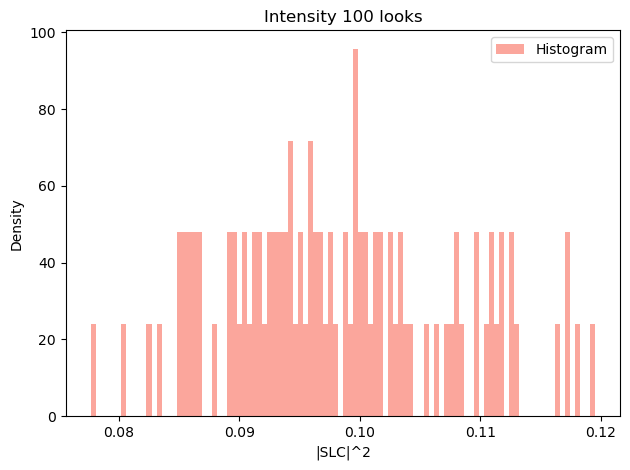

In [31]:
plot_intensity(intensity, 5, 20)